 # Please! Don't Overfit

In [2]:
import numpy as np 
import pandas as pd

In [3]:
#Reading Training data
data_df=pd.read_csv("train.csv")

In [4]:
data_df.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [5]:
data_df.shape

(250, 302)

**There is a good possibility of overfitting due to 300 features but only 250 records to train.**

In [6]:
#Seperating the features and label
X=data_df.iloc[:,2:].values
y=data_df.iloc[:,1].values

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

**Exploratory Data Analysis**  

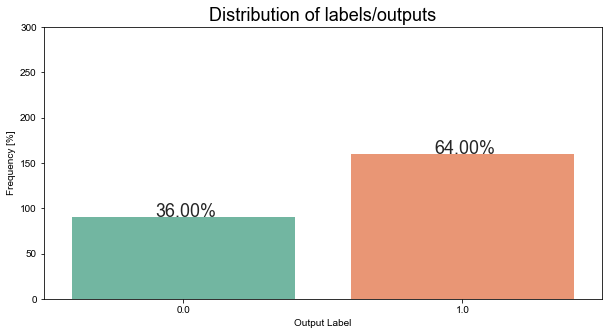

In [8]:
ax = sns.countplot(x = y ,palette="Set2")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=300)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(y)), (p.get_x()+ 0.3, p.get_height()))

plt.title('Distribution of labels/outputs')
plt.xlabel('Output Label')
plt.ylabel('Frequency [%]')
plt.show()

**Visualization to see the correlation between the different features.**

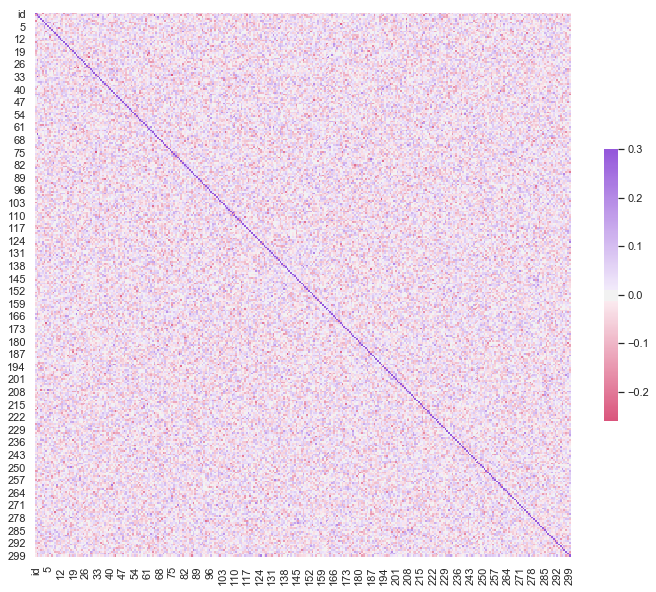

In [9]:
sns.set(style="white")

# Compute the correlation matrix
corr = data_df.corr()
plt.figure(figsize=(12,10))
cmap = sns.diverging_palette(0, 1000, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
             cbar_kws={"shrink": .5})

plt.show()

In [10]:
#Check for null data points
data_df.isnull().any().any()


False

**Standardizing the data** 

In [11]:
from sklearn.preprocessing import StandardScaler
stc=StandardScaler()
X_scale=stc.fit_transform(X)


**Splitting data into Training and Validation set**

In [12]:
#stratified K fold method to split Y 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
skf = StratifiedKFold(n_splits=5)

# Modeling

In [13]:
#function to calculate ROC score for various algos.Returns mean of 5 ROC scores.
def out_cross_val(model,X,y):
    score=[]
    for i,(train,test) in enumerate(skf.split(X,y)):
        X_train,X_test=X[train],X[test]
        y_train,y_test=y[train],y[test]
        model=model
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        rocscore=roc_auc_score(y_test,y_pred) 
        score.append(rocscore)
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(score), np.std(score)))   
    
    return np.mean(score), np.std(score)

***LOGISTIC REGRESSION***

In [14]:
from sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression(solver='liblinear')
log_score=out_cross_val(model_LR,X_scale,y)

CV mean score: 0.6955, std: 0.0310.


In [15]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_LR=confusion_matrix(y,model_LR.predict(X_scale))
cm_LR

array([[ 84,   6],
       [ 10, 150]], dtype=int64)

***SUPPORT VECTOR CLASSIFIER***

In [18]:
from sklearn.svm import SVC
classifier_svc=SVC(random_state=0,gamma='scale',probability=True)
from sklearn.model_selection import GridSearchCV
param_svc=[{'C':[1,5,10],'kernel':['rbf','linear']}]
gs_svc=GridSearchCV(estimator = classifier_svc,
                           param_grid = param_svc,
                           scoring = 'roc_auc',
                           cv = 10,
                           n_jobs = -1)
gs_svc=gs_svc.fit(X_scale,y)
print('the best score is:{}'.format(gs_svc.best_score_))
print('the best parameters are:{}'.format(gs_svc.best_params_)) 
means = gs_svc.cv_results_['mean_test_score']
stds = gs_svc.cv_results_['std_test_score']

classifier_svc=SVC(random_state=0,gamma='scale',probability=True,**gs_svc.best_params_)
svc_score=out_cross_val(classifier_svc,X_scale,y)
classifier_svc=classifier_svc.fit(X_scale,y)


the best score is:0.7652777777777777
the best parameters are:{'C': 1, 'kernel': 'linear'}
CV mean score: 0.6757, std: 0.0524.


In [19]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_svc=confusion_matrix(y,classifier_svc.predict(X))
cm_svc

array([[ 90,   0],
       [  0, 160]], dtype=int64)

In the above confusion matrix,there are ***0 cases of incorrect predictions***.Data is ***overfitted***.

***Gradient Boosting Classifier*** 

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
gbm0 = GradientBoostingClassifier(random_state=10)
GBM_score=out_cross_val(gbm0, X_scale, y)

CV mean score: 0.6153, std: 0.0697.


In [50]:
from sklearn.ensemble import GradientBoostingClassifier
param_gbm=[{'n_estimators':range(20,81,10),'max_depth':range(5,16,2)}]
gsearch_gbm = GridSearchCV(estimator = GradientBoostingClassifier(),param_grid = param_gbm,cv=5)
gsearch_gbm.fit(X_scale,y)
print('the best score is:{}'.format(gsearch_gbm.best_score_))
print('the best parameters are:{}'.format(gsearch_gbm.best_params_)) 
means = gsearch_gbm.cv_results_['mean_test_score']
stds = gsearch_gbm.cv_results_['std_test_score']

    
gbm0 = GradientBoostingClassifier(random_state=10,**gsearch_gbm.best_params_)
GBM_score=out_cross_val(gbm0, X_scale, y)

the best score is:0.672
the best parameters are:{'max_depth': 5, 'n_estimators': 50}
CV mean score: 0.6076, std: 0.0906.


Tried tuning various hyper parameters with no much improvement in the ROC score.

**Random Forest Classifier**

In [22]:
from sklearn.ensemble import RandomForestClassifier
model_RFC=RandomForestClassifier(n_estimators=1000, min_samples_leaf=25, max_features=0.5, n_jobs=-1, 
                                oob_score=True)
score_RFC=out_cross_val(model_RFC,X_scale,y)

CV mean score: 0.5813, std: 0.0466.


**Lasso model**

In [54]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
model_lasso = Lasso(alpha=0.01)
lasso_score=out_cross_val(model_lasso,X_scale,y)

CV mean score: 0.7781, std: 0.0314.


**Lasso Model with Feature selection**

In [51]:
# Set a minimum threshold of 0.01 by trial and error
sfm_lasso = SelectFromModel(model_lasso, threshold=0.001)
sfm_lasso.fit(X_scale, y)
X_transform = sfm_lasso.transform(X)
print('Numer of features after lasso regularization:{}'.format(X_transform.shape[1]))
lasso_featurescore=out_cross_val(model_lasso,X_transform,y)

Numer of features after lasso regularization:140
CV mean score: 0.9042, std: 0.0194.


Plotting box plot of all the scores calculated so far!

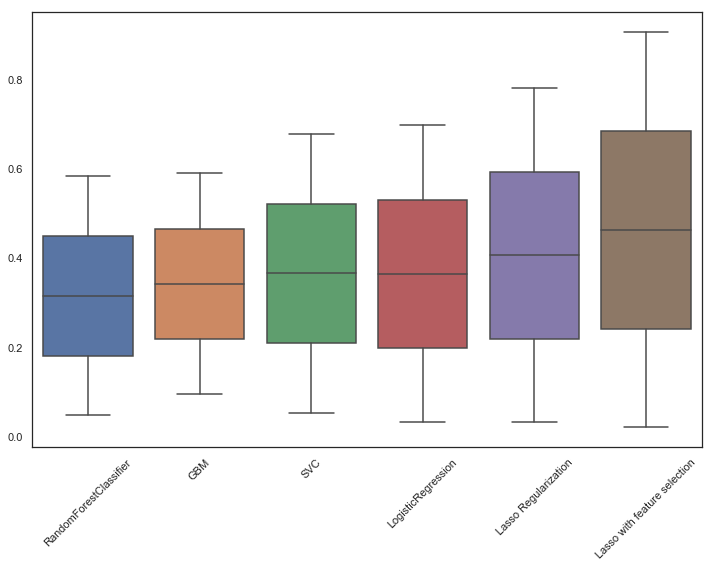

In [45]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame({'RandomForestClassifier': score_RFC})
scores_df['GBM'] = GBM_score
scores_df['SVC'] = svc_score
scores_df['LogisticRegression'] = log_score
scores_df['Lasso Regularization'] = lasso_score
scores_df['Lasso with feature selection'] = lasso_featurescore

sns.boxplot(data=scores_df);
plt.xticks(rotation=45);